# Ensemble Learning and Random Forests

If you aggregate the predictions of a group of predictors (such as classifiers or regressors), you will often get better predictions than with the best individual predictor. A group of predictors is called an *ensemble*; thus this technique is called *Ensemble Learning*, and an Ensemble Learning Algorithm is called *Ensemble method*.

As an example of Ensemble method, you can train a group of Decision Tree classifiers, eacb on a different random subset of training set. to make predictions, you obtain the predictions of all the individual trees, and then predict the class that gets the most votes. This Ensemble is known as *Random Forests*.

Below, we will discuss the most popular Ensemble methods, including *bagging, boosting* and *stacking*, and explore *Random Forests*.

## Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images")
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Voting Classifiers

In [2]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier

log_clf = LogisticRegression(solver="lbfgs", random_state=42)
svm_clf = SVC(gamma="scale", random_state=42)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

voting_clf = VotingClassifier(
    estimators=[
        ('lr', log_clf), ('svc', svm_clf), ('rf', rf_clf),
    ],
    voting='hard'
)

voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('svc', SVC(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42))])

In [4]:
from sklearn.metrics import accuracy_score

for clf in (log_clf, svm_clf, rf_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)    
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.85
SVC 0.87
RandomForestClassifier 0.88
VotingClassifier 0.87


#### Soft Voting

In [5]:
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
svm_clf = SVC(gamma="scale", probability=True, random_state=42)
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

voting_clf = VotingClassifier(
    estimators=[
        ('lr', log_clf), ('svc', svm_clf), ('rf', rf_clf),
    ],
    voting='soft'
)

for clf in (log_clf, svm_clf, rf_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)    
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))

LogisticRegression 0.85
SVC 0.87
RandomForestClassifier 0.88
VotingClassifier 0.89


## Bagging and Pasting

In both, bagging and pasting, the training instances are sampled several times across multiple predictors, but bagging 
allows sampling for the same predictor as well. This sampling when performed with *replacement* is called *bagging* while sampling *without replacement* is called *pasting*.

The below code trains an ensemble of 500 Decision Tree classifiers: each is trained on 100 training instances randomly sampled from the training set with replacement (to use pasting instead, set bootstrap=False). The n_jobs parameter tells how many CPU cores to use.

In [6]:
from sklearn.ensemble import BaggingClassifier

from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=100, bootstrap=True, n_jobs=-1)

bag_clf.fit(X_train, y_train)

y_pred = bag_clf.predict(X_test)

accuracy_score(y_test, y_pred)

0.9

In [7]:
bag_p_clf = BaggingClassifier(DecisionTreeClassifier(), n_estimators=500, max_samples=100, bootstrap=False, n_jobs=-1)

bag_p_clf.fit(X_train, y_train)

y_pred = bag_p_clf.predict(X_test)

accuracy_score(y_test, y_pred)

0.9

In [8]:
tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print(accuracy_score(y_test, y_pred_tree))

0.82


Saving figure decision_tree_without_and_with_bagging_plot


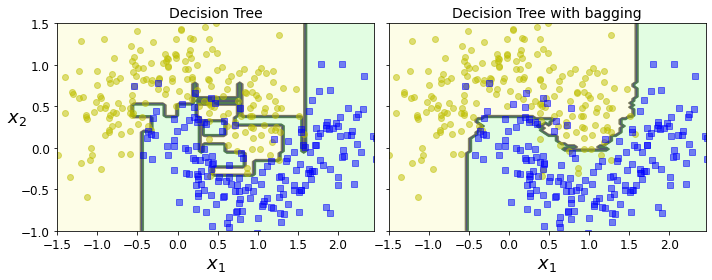

In [9]:
from matplotlib.colors import ListedColormap

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.45, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)    
    x1, x2 = np.meshgrid(x1s, x2s)
    
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    
    custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
    plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)

    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    
fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_decision_boundary(tree_clf, X_train, y_train)
plt.title('Decision Tree',fontsize=14)    

plt.sca(axes[1])
plot_decision_boundary(bag_clf, X_train, y_train)
plt.ylabel('')
plt.title('Decision Tree with bagging', fontsize=14)    

save_fig("decision_tree_without_and_with_bagging_plot")
plt.show()

## Random Forest

In [10]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)

rf_clf.fit(X_train, y_train)

y_pred_rf = rf_clf.predict(X_test)

accuracy_score(y_test, y_pred_rf)

0.89

In [11]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, max_samples=1.0, bootstrap=True, random_state=42)

bag_clf.fit(X, y)

y_pred_bag = bag_clf.predict(X_test)

accuracy_score(y_test, y_pred_bag)

0.93

In [12]:
np.sum(y_pred_bag == y_pred_rf) / len(y_pred_bag)  # almost identical predictions

0.96

#### Feature Importance

* Iris Dataset

In [13]:
from sklearn.datasets import load_iris

iris = load_iris()

rf_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)

rf_clf.fit(iris['data'], iris['target'])

for name, score in zip(iris['feature_names'], rf_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.10599880324508258
sepal width (cm) 0.026481285908525984
petal length (cm) 0.42442825580521776
petal width (cm) 0.44309165504117376


It seems that the petal length and petal width are the most important features.

* MNIST Dataset

In [14]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.target = mnist.target.astype(np.uint8)

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(mnist["data"], mnist["target"])

RandomForestClassifier(random_state=42)

Saving figure mnist_feature_importance_plot


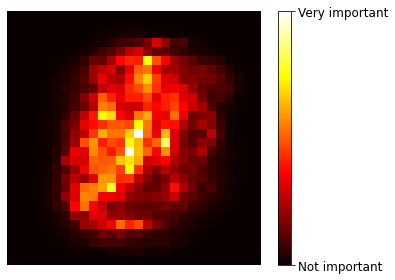

In [15]:
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.hot, interpolation="nearest")
    plt.axis("off")

plot_digit(rnd_clf.feature_importances_)

cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(), rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'])

save_fig("mnist_feature_importance_plot")
plt.show()

Random Forests are very handy to get a quick understanding of what features actually matter, in particular if you need to perform feature selection.

## Boosting

Boosting is an ensemble method that combine several weak learners into a strong learner. The general idea is to train predictors sequentially, each trying to correct its predecessor.

Adaboost and Gradient Boosting are most popular methods.

### Adaboost
One way for a new predictor to correct its predecessor is to pay a bit more attention to the training instances that the predecessor underfitted. This results in new predictors focussing more and more on the hard cases. This is the technique used by Adaboost.

In [16]:
from sklearn.ensemble import AdaBoostClassifier

# 200 decision stumps. A decision stump is a Decision Tree with max_depth=1.
ada_clf = AdaBoostClassifier(
            DecisionTreeClassifier(max_depth=1), n_estimators=200, algorithm='SAMME.R', learning_rate=0.5
        )

ada_clf.fit(X_train, y_train)

y_ada_pred = ada_clf.predict(X_test)

accuracy_score(y_test, y_ada_pred)

0.89

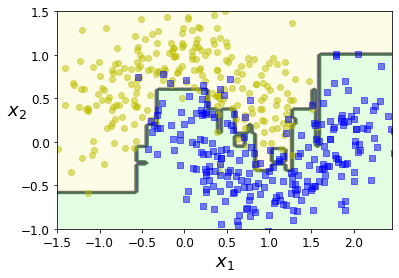

In [17]:
plot_decision_boundary(ada_clf, X, y)

## Gradient Boosting

In [18]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [19]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2)

tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2)

In [20]:
y2 = y - tree_reg1.predict(X)

tree_reg2 = DecisionTreeRegressor(max_depth=2)

tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2)

In [21]:
y3 = y2 - tree_reg2.predict(X)

tree_reg3 = DecisionTreeRegressor(max_depth=2)

tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2)

In [22]:
X_new = np.array([[0.8]])

y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))

y_pred

array([0.75026781])

In [23]:
def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

Saving figure gradient_boosting_plot


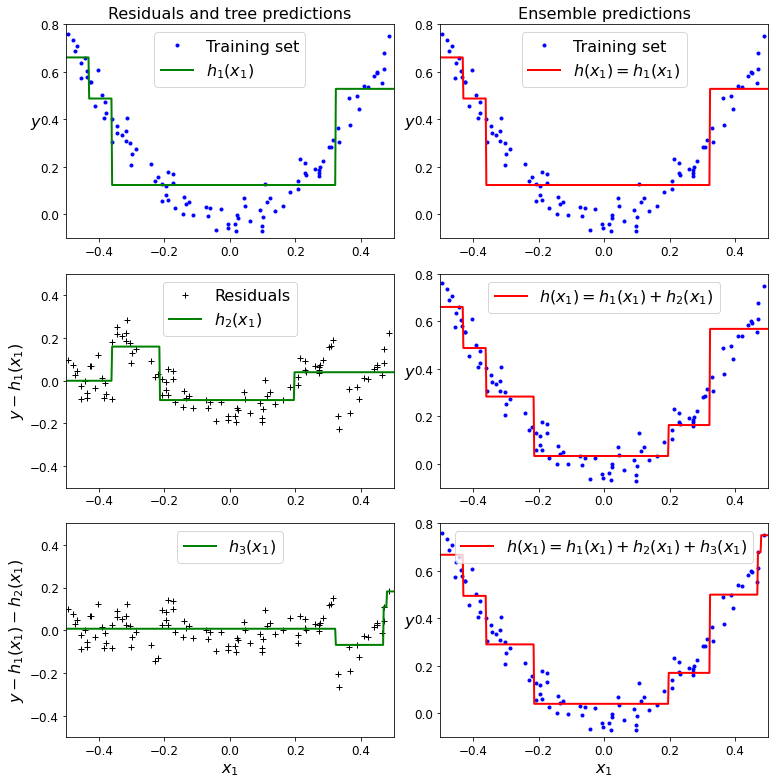

In [24]:

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

save_fig("gradient_boosting_plot")
plt.show()


The learning_rate hyperparameter scales the contribution of each tree. If it is set to a low value, such as 0.1, you will need more trees, but the prediction will generalize better. This regularization technique is called *shrinkage.*

Saving figure gbrt_learning_rate_plot


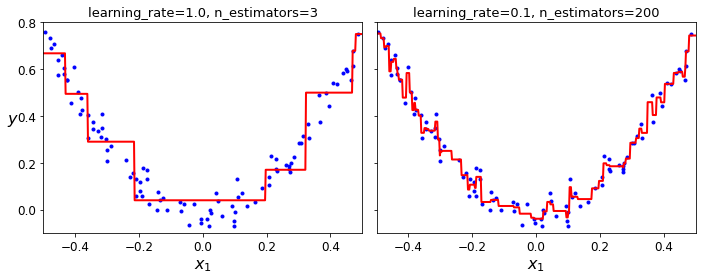

In [25]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0, random_state=42)
gbrt.fit(X, y)

gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

fix, axes = plt.subplots(ncols=2, figsize=(10,4), sharey=True)

plt.sca(axes[0])
plot_predictions([gbrt], X, y,  axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate=1.0, n_estimators=3", fontsize=13)
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.sca(axes[1])
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate=0.1, n_estimators=200", fontsize=13)
plt.xlabel("$x_1$", fontsize=16)

save_fig("gbrt_learning_rate_plot")
plt.show()

Left model does not have enough tree while the right model has too many causing to overfit.

#### Finding optimal number of trees

Use early stopping:
A simple way to implement it is by using the **staged_predict()** method.

The following code 
* trains a GBRT ensemble with 120 trees, 
* then measures the validation error at each stage of training to fing the optimal number of trees and 
* finally trains another GBRT ensemble using the optimal number of trees.

In [26]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)

y_pred = gbrt.fit(X_train, y_train)

errors = [mean_squared_error(y_test, y_pred) for y_pred in gbrt.staged_predict(X_test)]

best_n_estimators = np.argmin(errors) + 1

In [27]:
gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=best_n_estimators)

gbrt.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=53)

In [28]:
min_error = np.min(errors)

Saving figure early_stopping_gbrt_plot


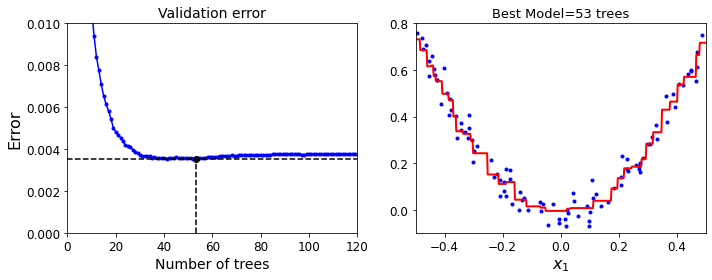

In [29]:
plt.figure(figsize=(10, 4))
plt.subplot(121)

plt.plot(errors, 'b.-')
plt.plot([best_n_estimators, best_n_estimators], [0, min_error], "k--")
plt.plot([0, 120], [min_error, min_error], "k--")
plt.plot(best_n_estimators, min_error, "ko")
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.ylabel("Error", fontsize=16)
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best Model={} trees".format(best_n_estimators), fontsize=13)
plt.xlabel("$x_1$", fontsize=16)

save_fig("early_stopping_gbrt_plot")
plt.show()

Implementing *early stopping*  early by setting **warm_start=True**.

In [30]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True)

min_val_error = float('inf')

error_going_up = 0

for n in range(1, 120):
    gbrt.n_estimators = n
    gbrt.fit(X_train, y_train)
    
    y_pred = gbrt.predict(X_test)
    
    val_error = mean_squared_error(y_test, y_pred)
    
    if val_error < min_val_error:
        min_val_error = val_error
        error_going_up = 0
    else:
        error_going_up += 1
        
    if error_going_up == 5:
        break;
        

In [31]:
print(gbrt.n_estimators)

47


In [32]:
print("Minimum validation MSE:", min_val_error)

Minimum validation MSE: 0.003554071291988297


## XGBoost

In [35]:
import xgboost

xgb_reg = xgboost.XGBRegressor()

xgb_reg.fit(X_train, y_train)

y_pred = xgb_reg.predict(X_test)

array([ 0.18352932,  0.53990245, -0.05502117,  0.5925422 ,  0.17648646,
       -0.06647426,  0.6788208 , -0.00935531,  0.13814175,  0.17648646,
       -0.00935531,  0.15585938,  0.50270784,  0.1666865 ,  0.28413954,
        0.5561252 ,  0.4757707 ,  0.36890447,  0.69101   ,  0.4757707 ,
        0.58049715,  0.13814175,  0.3462504 ,  0.18352932,  0.15585938],
      dtype=float32)

XGBoost with early stopping:

In [36]:
xgb_reg.fit(X_train, y_train, eval_set=[(X_test, y_test)], early_stopping_rounds=2)

y_pred = xgb_reg.predict(X_test)

y_pred

[0]	validation_0-rmse:0.21083
Will train until validation_0-rmse hasn't improved in 2 rounds.
[1]	validation_0-rmse:0.14897
[2]	validation_0-rmse:0.11373
[3]	validation_0-rmse:0.09167
[4]	validation_0-rmse:0.07759
[5]	validation_0-rmse:0.06909
[6]	validation_0-rmse:0.06445
[7]	validation_0-rmse:0.06278
[8]	validation_0-rmse:0.06152
[9]	validation_0-rmse:0.06114
[10]	validation_0-rmse:0.06077
[11]	validation_0-rmse:0.06146
[12]	validation_0-rmse:0.06154
Stopping. Best iteration:
[10]	validation_0-rmse:0.06077



array([ 0.1885474 ,  0.5384966 , -0.01354021,  0.58057415,  0.1885474 ,
        0.0152958 ,  0.67034435,  0.0152958 ,  0.12898493,  0.1885474 ,
        0.0152958 ,  0.1643205 ,  0.5021704 ,  0.15496236,  0.28682178,
        0.55297387,  0.47523323,  0.35735914,  0.68745124,  0.47523323,
        0.57613474,  0.12898493,  0.33966637,  0.1885474 ,  0.1643205 ],
      dtype=float32)